# Causal Inference Notebook

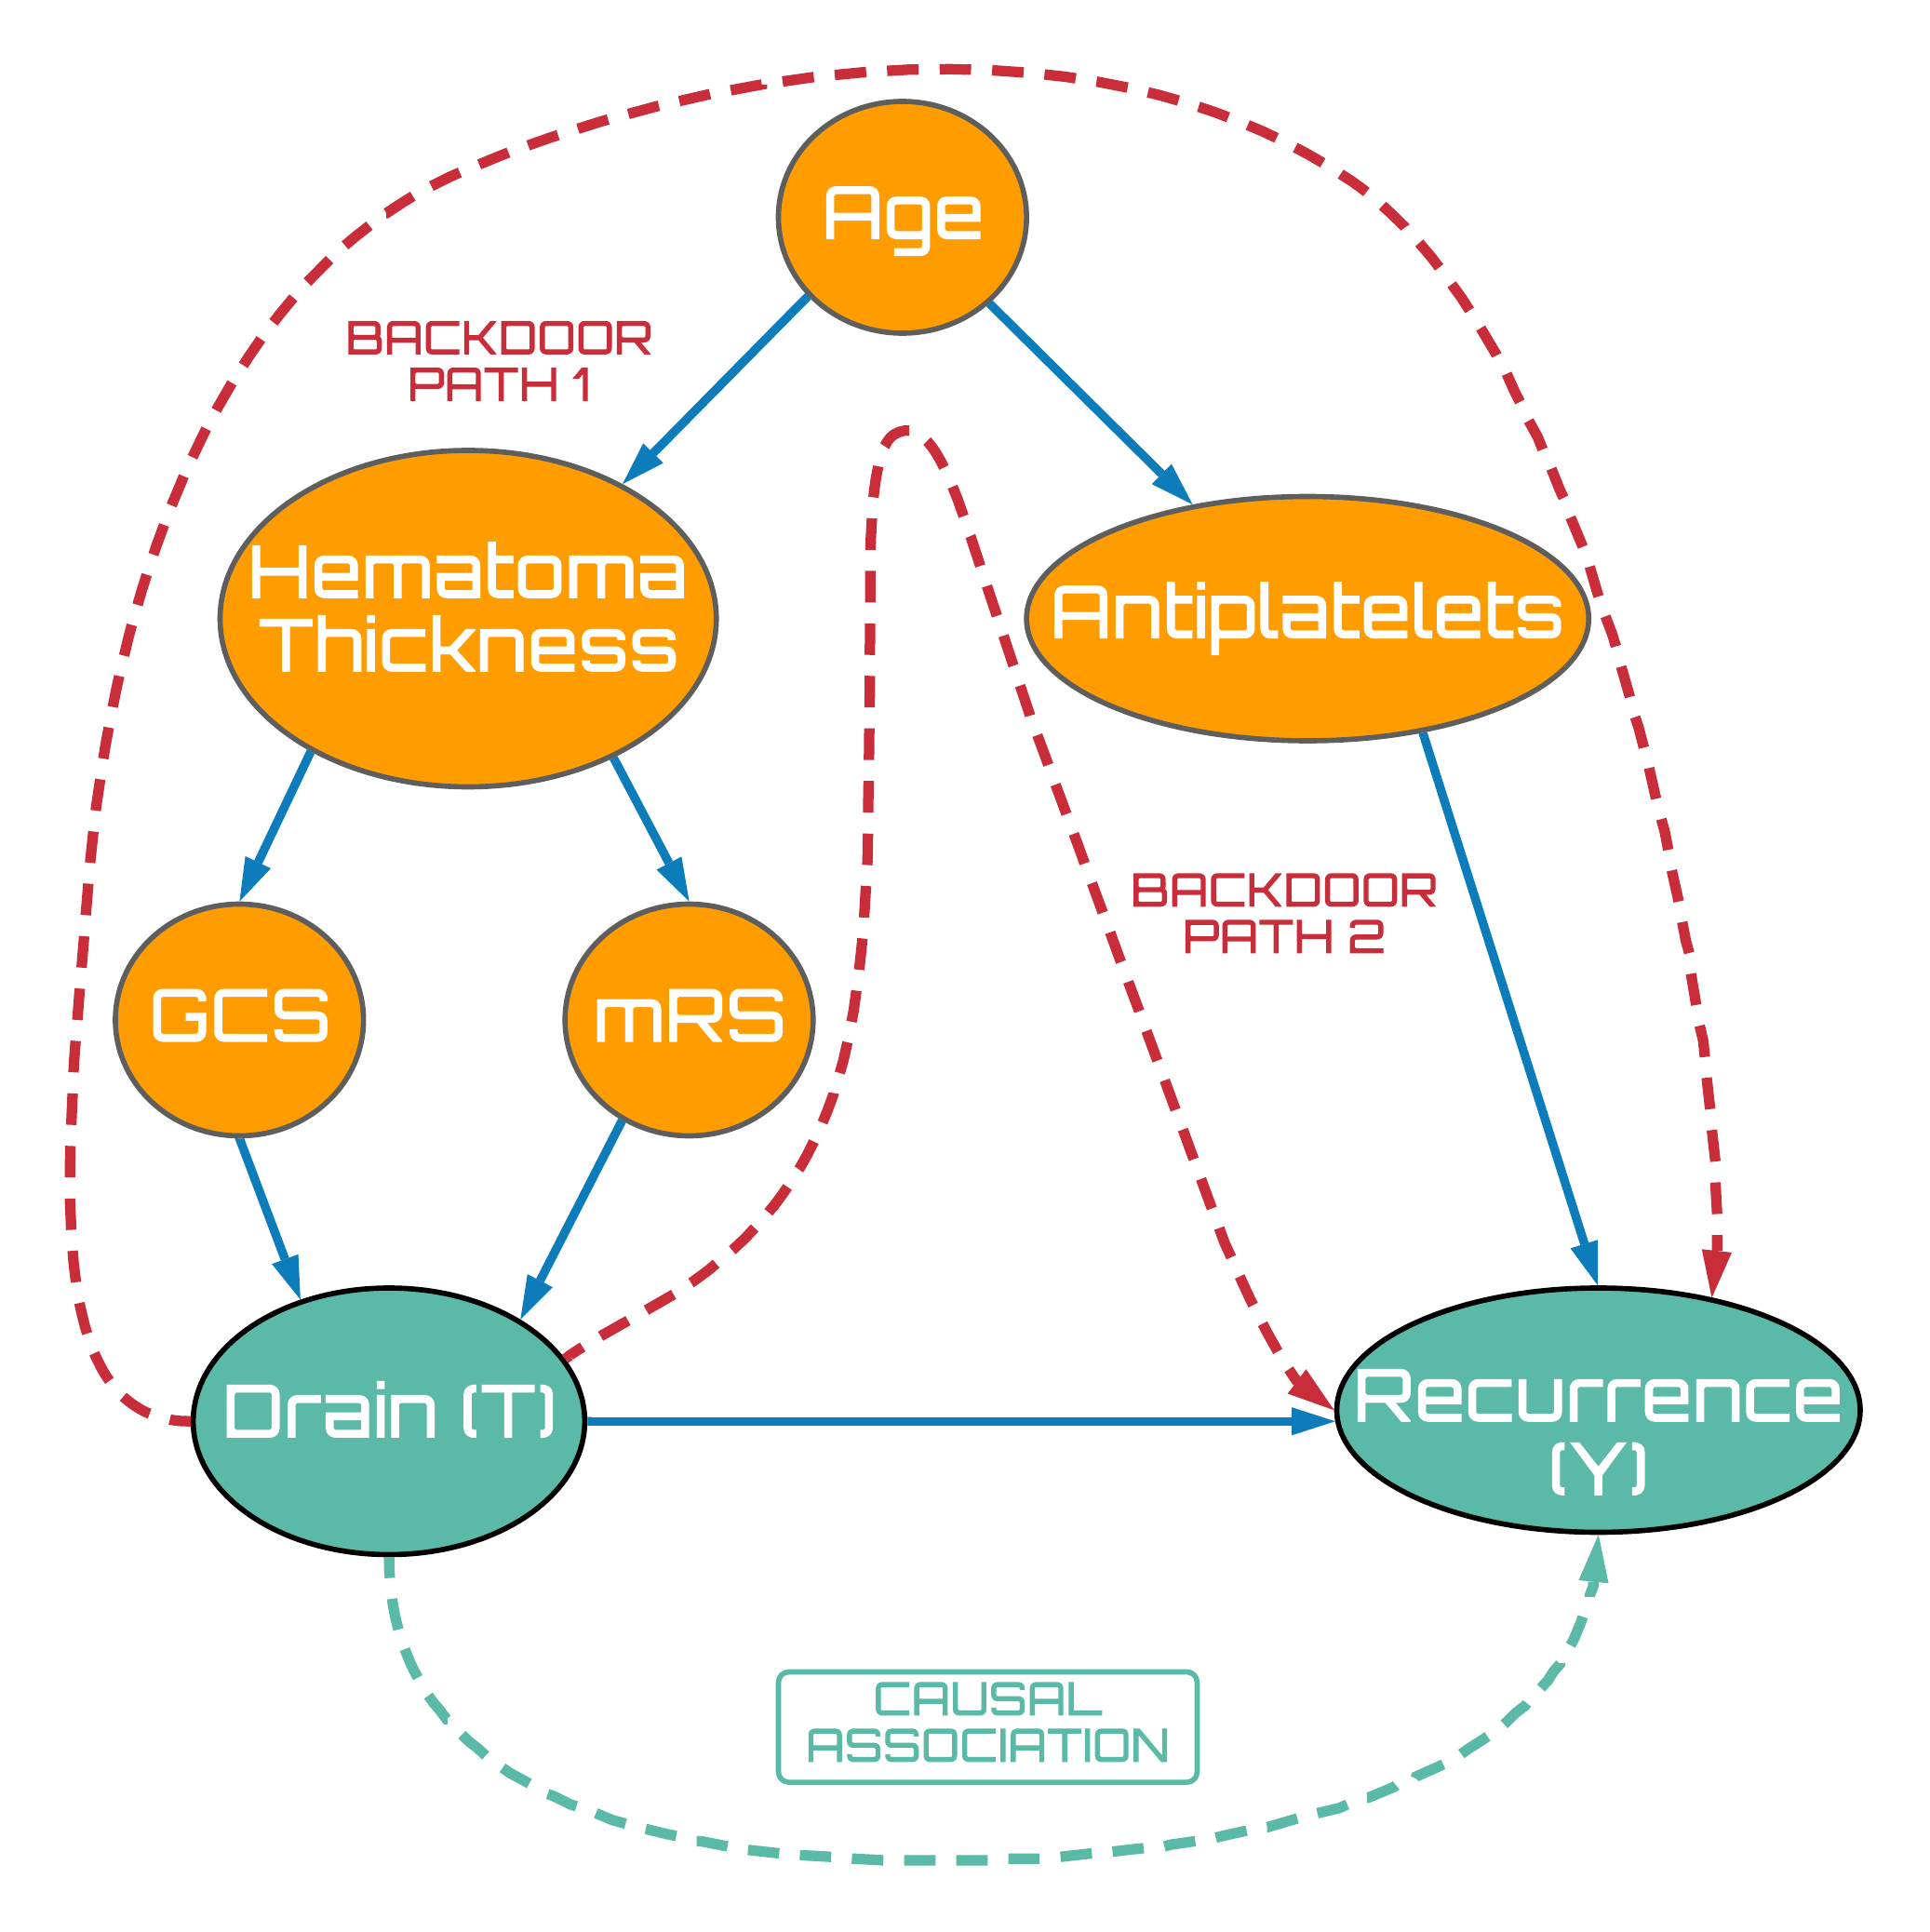

## Imports

In [1]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel

# Avoid printing dataconversion warnings from sklearn
import warnings
from sklearn.exceptions import DataConversionWarning
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
from IPython.display import Image, display


In [2]:
DATA_FILENAME = "csdh_clean.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME

csdh = pd.read_csv(DATA_FILEPATH)

In [3]:
# Grab relevant features from dataset
csdh_01 = csdh[['age', 'antiplatelet', 'thickness_sum', 'gcs_preop', 'adm_mrs', 'drain', 'recurrence']]
# Convert ints/floats to bools for DoWhy package
csdh_01['antiplatelet'] = csdh_01['antiplatelet'].astype(bool)
csdh_01['drain'] = csdh_01['drain'].astype(bool)
csdh_01['recurrence'] = csdh_01['recurrence'].astype(bool)

In [4]:
csdh_01.head()

,age,antiplatelet,thickness_sum,gcs_preop,adm_mrs,drain,recurrence
0,20,False,20,15,1,False,True
1,23,False,6,14,2,True,False
2,23,False,22,15,2,True,False
3,23,False,8,15,0,False,False
4,28,False,10,15,3,False,False


## Formulate causal graph

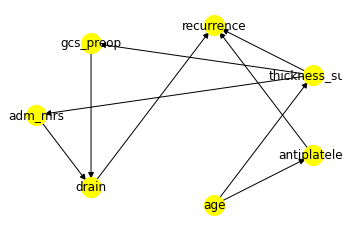

In [5]:
# I. Create a causal model from the data and given graph.
causal_graph = "digraph {adm_mrs -> drain;age -> antiplatelet;age -> thickness_sum;antiplatelet -> recurrence;drain -> recurrence;gcs_preop -> drain;thickness_sum -> adm_mrs;thickness_sum -> gcs_preop;thickness_sum -> recurrence;}"""
model = CausalModel(data=csdh_01, treatment='drain', outcome='recurrence', graph=causal_graph)
model.view_model()

In [18]:
# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# III. Estimate the target estimand using a statistical method.

# Linear regression
linear_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                        control_value=False,
                                        treatment_value=True,
                                        target_units='ate'
                                       )
# Propensity score matching
prop_match_estimate = model.estimate_effect(identified_estimand,
                                      method_name="backdoor.propensity_score_matching",
                                      control_value=False,
                                      treatment_value=True
                                     )

# Propensity score stratification
prop_strat_estimate = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_stratification", 
                                            method_params={'num_strata':10, 'clipping_threshold':5},
                                            control_value=False,
                                            treatment_value=True,
                                            target_units='ate'
                                           )
# Propensity score weighting
prop_weight_estimate = model.estimate_effect(identified_estimand,
                                             method_name="backdoor.propensity_score_weighting",
                                             control_value=False,
                                             treatment_value=True,
                                             target_units='ate'
                                            )

/opt/anaconda3/envs/csdh/lib/python3.9/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/opt/anaconda3/envs/csdh/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


In [19]:
print("Linear causal estimate is " + str(linear_estimate.value))
print("Propensity score matching causal estimate is " + str(prop_match_estimate.value))
print("Propsensity score stratification causal estimate is " + str(prop_strat_estimate.value))
print("Propensity score weighting causal estimate is " + str(prop_weight_estimate.value))

Linear causal estimate is -0.10562889672174276
Propensity score matching causal estimate is -0.06711409395973154
Propsensity score stratification causal estimate is -0.1040170194916153
Propensity score weighting causal estimate is -0.11267092630556234


In [32]:
# IV. Refute causal estimate with checks
res_cause = model.refute_estimate(identified_estimand, linear_estimate,
                                       method_name="random_common_cause")

res_placebo = model.refute_estimate(identified_estimand, linear_estimate,
                                    method_name="placebo_treatment_refuter", placebo_type="permute")

res_subset = model.refute_estimate(identified_estimand, linear_estimate,
                                   method_name="data_subset_refuter", subset_fraction=0.9)


In [33]:
print(res_cause) # CE should stay the same
print(res_placebo) # CE should go to zero
print(res_subset) # CE should stay the same

Refute: Add a Random Common Cause
Estimated effect:-0.10562889672174276
New effect:-0.10548768467288218

Refute: Use a Placebo Treatment
Estimated effect:-0.10562889672174276
New effect:-0.004670302993681619
p value:0.48

Refute: Use a subset of data
Estimated effect:-0.10562889672174276
New effect:-0.10448124454239809
p value:0.46

